In this exercise, we build on the previous exercises to prepare a labeled dataset of binary feature vectors, and use it to train a *Random Forest* binary classifier of malware/benign feature vectors. 

In [2]:
import os
directoriesWithLabels = [("/home/ec2-user/SageMaker/Samples/Benign",0), ("/home/ec2-user/SageMaker/Samples/Malware",1)]
listOfSamples = []
labels = []
for datasetPath, label in directoriesWithLabels:
    samples = [f for f in os.listdir(datasetPath)]
    for file in samples:
        filePath = os.path.join(datasetPath, file)
        listOfSamples.append(filePath)
        labels.append(label)

In [3]:
!pip install nltk pefile

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.8/71.8 kB 11.2 MB/s eta 0:00:00


In [ ]:
pip install git+https://github.com/elastic/ember.git

  Cloning https://github.com/elastic/ember.git to /tmp/pip-req-build-z_wz787l
  Running command git clone --filter=blob:none --quiet https://github.com/elastic/ember.git /tmp/pip-req-build-z_wz787l
  Resolved https://github.com/elastic/ember.git to commit d97a0b523de02f3fe5ea6089d080abacab6ee931
  Preparing metadata (setup.py) ... done
  Created wheel for ember: filename=ember-0.1.0-py3-none-any.whl size=13050 sha256=ddcee7c3c9230cf67fb1a6e460ad0042324aaca76cb2f4f6c8d56b08282da977
  Stored in directory: /tmp/pip-ephem-wheel-cache-ekl0q8ml/wheels/7a/af/81/7e3bd4d43fd62c37273aa84e0720752df8dbc9c43700279961
Successfully built ember
Note: you may need to restart the kernel to use updated packages.


In [4]:
#Train-Test data split
from sklearn.model_selection import train_test_split
samples_train, samples_test, labels_train, labels_test = train_test_split(listOfSamples, labels, test_size=0.33, stratify=labels, random_state=42)

In [5]:
import collections
from nltk import ngrams
import numpy as np
import pefile

def readFile(filePath):
    with open(filePath, "rb") as binary_file:
        data = binary_file.read()
    return data

def byteSequenceToNgrams(byteSequence, n):
    Ngrams = ngrams(byteSequence, n)
    return list(Ngrams)
    
def extractNgramCounts(file, N):
    fileByteSequence = readFile(file)
    fileNgrams = byteSequenceToNgrams(fileByteSequence, N)
    return collections.Counter(fileNgrams)

def getNGramFeaturesFromSample(file, K1_most_common_Ngrams_list):
    K1 = len(K1_most_common_Ngrams_list)
    fv = K1*[0]
    fileNgrams = extractNgramCounts(file, N)
    for i in range(K1):
        fv[i]=fileNgrams[K1_most_common_Ngrams_list[i]]
    return fv

def preprocessImports(listOfDLLs):
    processedListOfDLLs = []
    temp = [x.decode().split(".")[0].lower() for x in listOfDLLs]
    return " ".join(temp)

def getImports(pe):
    listOfImports = []
    for entry in pe.DIRECTORY_ENTRY_IMPORT:
        listOfImports.append(entry.dll)
    return preprocessImports(listOfImports)

def getSectionNames(pe):
    listOfSectionNames = []
    for eachSection in pe.sections:
        refined_name = eachSection.Name.decode().replace('\x00','').lower()
        listOfSectionNames.append(refined_name)
    return " ".join(listOfSectionNames)

In [6]:
# Generate 2-Grams, 
# and produce feature vectors based on the frequency method
# This may take a few minutes to run
N=2
totalNgramCount = collections.Counter([])
for file in samples_train:
    totalNgramCount += extractNgramCounts(file, N)
K1 = 100
K1_most_common_Ngrams = totalNgramCount.most_common(K1)
K1_most_common_Ngrams_list = [x[0] for x in K1_most_common_Ngrams]
print(K1_most_common_Ngrams_list)

[(0, 0), (255, 255), (204, 204), (2, 100), (1, 0), (0, 139), (131, 196), (2, 0), (68, 36), (139, 69), (0, 131), (255, 117), (133, 192), (255, 139), (254, 255), (46, 46), (141, 77), (139, 77), (255, 21), (7, 0), (69, 252), (76, 36), (8, 139), (0, 1), (4, 0), (4, 139), (137, 69), (141, 69), (255, 131), (0, 137), (51, 192), (0, 255), (80, 232), (255, 141), (85, 139), (8, 0), (0, 232), (15, 182), (0, 116), (3, 100), (139, 236), (80, 141), (100, 0), (15, 132), (12, 139), (64, 0), (255, 0), (84, 36), (253, 255), (65, 68), (73, 78), (80, 65), (68, 68), (78, 71), (68, 73), (0, 204), (16, 0), (198, 69), (192, 116), (199, 69), (80, 255), (204, 139), (3, 0), (4, 137), (139, 68), (116, 36), (101, 0), (139, 76), (106, 0), (100, 139), (0, 8), (64, 2), (196, 12), (139, 70), (36, 8), (0, 89), (69, 8), (196, 4), (117, 8), (32, 0), (86, 139), (2, 101), (95, 94), (0, 16), (131, 192), (139, 255), (0, 72), (100, 232), (0, 80), (0, 117), (195, 204), (36, 20), (139, 240), (9, 0), (0, 141), (36, 16), (1, 100)

In [7]:
# Extract N-gram features based on the frequency method
# Also, extracts some metadata such as DLL imports, 
# and PE Sections. We will combine these with
# our N-gram features to enrich the sample representation.
# This will take a few minutes to run.
# Some samples will generate errors such as 'not a PE file',
# 'DOS header not found', and 'invalid attribute'. These are OK.
importsCorpus_train = []
numSections_train = []
sectionNames_train = []
NgramFeaturesList_train = []
y_train = []
for i in range(len(samples_train)):
    file = samples_train[i]
    try:
        NGramFeatures = getNGramFeaturesFromSample(file, K1_most_common_Ngrams_list)
        pe = pefile.PE(file)
        imports = getImports(pe)
        nSections = len(pe.sections)
        secNames = getSectionNames(pe)
        importsCorpus_train.append(imports)
        numSections_train.append(nSections)
        sectionNames_train.append(secNames)
        NgramFeaturesList_train.append(NGramFeatures)
        y_train.append(labels_train[i])
    except Exception as e: 
        print(file+":")
        print(e)

/home/ec2-user/SageMaker/Samples/Benign/RegAsm.exe:
'PE' object has no attribute 'DIRECTORY_ENTRY_IMPORT'
/home/ec2-user/SageMaker/Samples/Benign/pmsort.exe:
'Invalid e_lfanew value, probably not a PE file'
/home/ec2-user/SageMaker/Samples/Benign/oisicon.exe:
'PE' object has no attribute 'DIRECTORY_ENTRY_IMPORT'
/home/ec2-user/SageMaker/Samples/Benign/BootExpCfg.exe:
'DOS Header magic not found.'
/home/ec2-user/SageMaker/Samples/Malware/VirusShare_1a89b7d4fb8ded72e1f8e81ee9352262.exe:
'utf-8' codec can't decode byte 0xb1 in position 0: invalid start byte
/home/ec2-user/SageMaker/Samples/Benign/sysprep.exe:
'DOS Header magic not found.'
/home/ec2-user/SageMaker/Samples/Benign/urlproxy.exe:
'Invalid NT Headers signature. Probably a NE file'
/home/ec2-user/SageMaker/Samples/Benign/LockAppHost.exe:
'DOS Header magic not found.'
/home/ec2-user/SageMaker/Samples/Benign/pmgrant.exe:
'Invalid e_lfanew value, probably not a PE file'
/home/ec2-user/SageMaker/Samples/Benign/adaminstall.exe:
'DOS 

In [8]:
importsCorpus_train

['kernel32 user32 advapi32 ole32 msvcrt loadperf ws2_32',
 'ws2_32 rpcrt4 kernel32 user32 advapi32 ole32 oleaut32',
 'libgcc_s_seh-1 libstdc++-6 kernel32 msvcrt',
 'ws2_32 rpcrt4 kernel32 user32 advapi32 ole32 oleaut32',
 'msys-1 msys-intl-8 kernel32',
 'ws2_32 rpcrt4 kernel32 user32 advapi32 ole32 oleaut32',
 'kernel32 user32 advapi32 ole32 msvcrt loadperf ws2_32',
 'msys-1 msys-intl-8 kernel32',
 'ntoskrnl hal',
 'ws2_32 rpcrt4 kernel32 user32 advapi32 ole32 oleaut32',
 'msvcrt ntdll api-ms-win-core-file-l1-2-1 api-ms-win-core-processthreads-l1-1-2 api-ms-win-core-memory-l1-1-2 api-ms-win-core-console-l2-1-0 api-ms-win-core-localization-l1-2-1 api-ms-win-core-synch-l1-2-0 api-ms-win-core-console-l1-1-0 api-ms-win-core-processenvironment-l1-2-0 api-ms-win-core-errorhandling-l1-1-1 api-ms-win-core-file-l1-2-2 api-ms-win-core-heap-l1-2-0 api-ms-win-core-handle-l1-1-0 api-ms-win-core-libraryloader-l1-2-0 api-ms-win-core-profile-l1-1-0 api-ms-win-core-sysinfo-l1-2-1 api-ms-win-core-kernel

In [9]:
numSections_train

[9,
 5,
 11,
 5,
 5,
 5,
 9,
 5,
 6,
 5,
 7,
 5,
 7,
 9,
 6,
 6,
 5,
 9,
 11,
 5,
 6,
 5,
 5,
 6,
 11,
 5,
 5,
 5,
 6,
 3,
 3,
 6,
 6,
 9,
 6,
 7,
 6,
 5,
 5,
 5,
 9,
 6,
 3,
 9,
 5,
 11,
 9,
 6,
 5,
 5,
 5,
 5,
 5,
 3,
 5,
 6,
 5,
 6,
 6,
 6,
 5,
 6,
 4,
 9,
 5,
 5,
 5,
 6,
 6,
 3,
 5,
 9,
 5,
 6,
 5,
 5,
 3,
 6,
 4,
 9,
 5,
 6,
 9,
 5,
 6,
 7,
 5,
 6,
 5,
 6,
 3,
 5,
 6,
 5,
 5,
 9,
 7,
 3,
 11,
 11,
 3,
 5,
 5,
 6,
 6,
 5,
 6,
 9,
 9,
 6,
 9,
 5,
 5,
 6,
 5,
 3,
 6,
 5,
 7,
 5,
 5,
 6,
 5,
 11,
 5,
 6,
 5,
 6,
 6,
 11,
 6,
 6,
 5,
 5,
 6,
 5,
 11,
 5,
 5,
 5,
 6,
 5,
 5,
 11,
 5,
 5,
 5,
 6,
 5,
 9,
 5,
 6,
 5,
 9,
 6,
 5,
 9,
 9,
 5,
 6,
 5,
 6,
 5,
 3,
 9,
 5,
 5,
 5,
 6,
 7,
 5,
 3,
 6,
 5,
 5,
 5,
 3,
 5,
 5,
 10,
 5,
 5,
 9,
 6,
 9,
 6,
 6,
 5,
 11,
 11,
 6,
 6,
 6,
 5,
 5,
 4,
 5,
 5,
 6,
 5,
 5,
 5,
 5,
 9,
 6,
 5,
 6,
 5,
 6,
 10,
 5,
 5,
 5,
 5,
 5,
 9,
 5,
 6,
 6,
 6,
 11,
 5,
 11,
 5,
 3,
 5,
 5,
 6,
 5,
 7,
 3,
 5,
 5,
 5,
 6,
 11,
 11,
 5,
 11,
 3,
 11,
 5,
 5,
 5,
 6,


In [10]:
sectionNames_train

['upx1 .text .b .rdata .edata .data .edata .txjuj .rsrc',
 '.text .rdata .data .rsrc .reloc',
 '.text .data .rdata .pdata .xdata .bss .edata .idata .crt .tls .reloc',
 '.text .rdata .data .rsrc .reloc',
 '.text .data .data_cy .bss .idata',
 '.text .rdata .data .rsrc .reloc',
 'upx1 .text .b .rdata .edata .data .edata .txjuj .rsrc',
 '.text .data .data_cy .bss .idata',
 '.text .rdata .data init .rsrc .reloc',
 '.text .rdata .data .rsrc .reloc',
 '.text .rdata .data .pdata .didat .rsrc .reloc',
 '.text .rdata .data .rsrc .reloc',
 '.text .imrsiv .rdata .data .pdata .rsrc .reloc',
 '.text .data .rdata .pdata .xdata .bss .idata .crt .tls',
 '.text .rdata .data init .rsrc .reloc',
 '.text .data .idata .didat .rsrc .reloc',
 '.text .rdata .data .rsrc .reloc',
 '.text .data .rdata .pdata .xdata .bss .idata .crt .tls',
 '.text .data .rdata .pdata .xdata .bss .idata .crt .tls .rsrc /4',
 '.text .rdata .data .rsrc .reloc',
 '.text .rdata .data init .rsrc .reloc',
 '.text .rdata .data .rsrc .relo

In [11]:
NgramFeaturesList_train

[[11584,
  53,
  41,
  6,
  504,
  155,
  4,
  447,
  4,
  43,
  84,
  1,
  2,
  6,
  4,
  7,
  3,
  5,
  48,
  33,
  18,
  6,
  11,
  136,
  167,
  5,
  76,
  0,
  4,
  92,
  4,
  78,
  14,
  8,
  15,
  63,
  54,
  10,
  15,
  4,
  15,
  7,
  14,
  12,
  5,
  141,
  18,
  4,
  2,
  77,
  64,
  70,
  96,
  69,
  64,
  4,
  133,
  8,
  11,
  5,
  15,
  4,
  52,
  2,
  3,
  5,
  44,
  3,
  64,
  3,
  68,
  18,
  2,
  6,
  2,
  7,
  48,
  12,
  44,
  55,
  7,
  0,
  2,
  117,
  4,
  1,
  23,
  2,
  59,
  17,
  5,
  8,
  3,
  53,
  277,
  5,
  5,
  71,
  39,
  1],
 [41825,
  3043,
  2603,
  2956,
  932,
  762,
  871,
  621,
  737,
  525,
  657,
  504,
  497,
  387,
  441,
  3,
  513,
  383,
  396,
  133,
  424,
  464,
  356,
  313,
  306,
  302,
  387,
  327,
  417,
  325,
  354,
  320,
  308,
  360,
  204,
  228,
  228,
  298,
  229,
  333,
  173,
  303,
  350,
  252,
  285,
  73,
  306,
  307,
  271,
  347,
  345,
  345,
  341,
  342,
  341,
  135,
  219,
  325,
  232,
  268,
  235,
  10

In [12]:
labels_train

[1,
 1,
 0,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 1,
 1,
 1,
 0,
 0,
 1,
 0,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 0,
 1,
 0,
 1,
 1,
 0,
 1,
 0,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 1,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 1,
 0,
 1,
 0,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 0,
 0,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 1,
 1,
 1,
 0,
 0,
 1,
 0,
 1,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,


In the following lines, we define a pipeline of sequential transforms (HashingVectorizer and TfidfTransformer) to extract N-gram featurs and construct feature vectors from the DLL imports and Section names extracted for each sample. 

In [10]:
from sklearn.feature_extraction.text import HashingVectorizer, TfidfTransformer
from sklearn.pipeline import Pipeline
imports_featurizer = Pipeline([('vect', HashingVectorizer(input='content', ngram_range=(1, 2))),('tfidf', TfidfTransformer(use_idf=True, )),])
section_names_featurizer = Pipeline([('vect', HashingVectorizer(input='content', ngram_range=(1, 2))),('tfidf', TfidfTransformer(use_idf=True, )),])
importsCorpus_train_transformed = imports_featurizer.fit_transform(importsCorpus_train)
sectionNames_train_transformed = section_names_featurizer.fit_transform(sectionNames_train)

In [11]:
# Combine the binary N-gram features with 
# the DLL imports and section names features to create
# vectorized training samples
from scipy.sparse import hstack, csr_matrix
X_train = hstack([NgramFeaturesList_train, importsCorpus_train_transformed,sectionNames_train_transformed, csr_matrix(numSections_train).transpose()])

In [ ]:
import pandas as pd
from scipy.sparse import csr_matrix
import pickle

# Convert training features to pandas DataFrame
X_train_df = pd.DataFrame.sparse.from_spmatrix(X_train)

# Save training features to CSV
X_train_df.to_csv('X_train_features.csv', index=False)

# Convert testing features to pandas DataFrame
X_test_df = pd.DataFrame.sparse.from_spmatrix(X_test)

# Save testing features to CSV
X_test_df.to_csv('X_test_features.csv', index=False)

# Now, both X_train_df and X_test_df are pandas DataFrames containing your features.
# You can use them for further analysis or processing as needed.


In [ ]:
print(X_train_df.head())

In [13]:
import joblib

#Train the Random Forest classifier
# This may take a few minutes.
from sklearn.ensemble import RandomForestClassifier
clf=RandomForestClassifier(n_estimators=1)
clf = clf.fit(X_train,y_train)
joblib.dump(clf, 'model.joblib')

# # Save the trained model to a file
# with open('random_forest_model.pkl', 'wb') as f:
#     pickle.dump(clf, f)
    
print(dir(clf))


['__abstractmethods__', '__annotations__', '__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__getitem__', '__getstate__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__iter__', '__le__', '__len__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__setstate__', '__sizeof__', '__sklearn_clone__', '__str__', '__subclasshook__', '__weakref__', '_abc_impl', '_build_request_for_signature', '_check_feature_names', '_check_n_features', '_compute_oob_predictions', '_doc_link_module', '_doc_link_template', '_doc_link_url_param_generator', '_estimator_type', '_get_default_requests', '_get_doc_link', '_get_estimators_indices', '_get_metadata_request', '_get_oob_predictions', '_get_param_names', '_get_tags', '_make_estimator', '_more_tags', '_n_samples', '_n_samples_bootstrap', '_parameter_constraints', '_repr_html_', '_repr_html_inner', '_repr_mimebundle_', '_requ

In [14]:
# Training accuracy
clf.score(X_train, y_train)

0.9978947368421053

In [12]:
# Generate feature vectors for the test samples
# This may take a few minutes
importsCorpus_test = []
numSections_test = []
sectionNames_test = []
NgramFeaturesList_test = []
y_test = []
for i in range(len(samples_test)):
    file = samples_test[i]
    try:
        NGramFeatures = getNGramFeaturesFromSample(file, K1_most_common_Ngrams_list)
        pe = pefile.PE(file)
        imports = getImports(pe)
        nSections = len(pe.sections)
        secNames = getSectionNames(pe)
        importsCorpus_test.append(imports)
        numSections_test.append(nSections)
        sectionNames_test.append(secNames)
        NgramFeaturesList_test.append(NGramFeatures)
        y_test.append(labels_test[i])
    except Exception as e: 
        print(file+":")
        print(e)

/home/ec2-user/SageMaker/Samples/Malware/VirusShare_7a30183b105b4200fc201925aba4886c.exe:
'utf-8' codec can't decode byte 0xb8 in position 0: invalid start byte
/home/ec2-user/SageMaker/Samples/Malware/VirusShare_14f3035781bb698c37ad287483af569e.exe:
'utf-8' codec can't decode byte 0x8d in position 0: invalid start byte
/home/ec2-user/SageMaker/Samples/Benign/ldifde.exe:
'DOS Header magic not found.'
/home/ec2-user/SageMaker/Samples/Benign/newmail.exe:
'Invalid e_lfanew value, probably not a PE file'
/home/ec2-user/SageMaker/Samples/Benign/InstallUtil.exe:
'PE' object has no attribute 'DIRECTORY_ENTRY_IMPORT'
/home/ec2-user/SageMaker/Samples/Benign/Common.DBConnection64.exe:
'PE' object has no attribute 'DIRECTORY_ENTRY_IMPORT'
/home/ec2-user/SageMaker/Samples/Benign/aspnetca.exe:
'DOS Header magic not found.'
/home/ec2-user/SageMaker/Samples/Benign/evntwin.exe:
'DOS Header magic not found.'


In [25]:
labels_train

[1,
 1,
 0,
 1,
 1,
 1,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 0,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 0,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 1,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 0,
 1,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 1]

In [15]:
importsCorpus_test_transformed = imports_featurizer.transform(importsCorpus_test)
sectionNames_test_transformed = section_names_featurizer.transform(sectionNames_test)
X_test = hstack([NgramFeaturesList_test, importsCorpus_test_transformed,sectionNames_test_transformed, csr_matrix(numSections_test).transpose()])

In [16]:
clf.score(X_test, y_test)

0.9957446808510638

In [27]:
from sklearn.metrics import accuracy_score
y_predict = clf.predict(X_test)
accuracy = accuracy_score(y_test, y_predict)
print('Accuracy:', accuracy)

Accuracy: 0.9914893617021276


In [28]:
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix

precision_score(y_test, y_predict)

0.9929577464788732

In [33]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

# Training accuracy
training_accuracy = accuracy_score(y_train, clf.predict(X_train))
print("Training Accuracy:", training_accuracy)


Training Accuracy: 0.9978947368421053


In [34]:
# Test accuracy
test_accuracy = accuracy_score(y_test, clf.predict(X_test))
print("Test Accuracy:", test_accuracy)

Test Accuracy: 0.9914893617021276


In [35]:
# Precision
precision = precision_score(y_test, clf.predict(X_test))
print("Precision:", precision)

Precision: 0.9929577464788732


In [36]:
# Recall
recall = recall_score(y_test, clf.predict(X_test))
print("Recall:", recall)

Recall: 0.9929577464788732


In [37]:
# F1 score
f1 = f1_score(y_test, clf.predict(X_test))
print("F1 Score:", f1)

F1 Score: 0.9929577464788732


Confusion Matrix:
 [[ 92   1]
 [  0 142]]


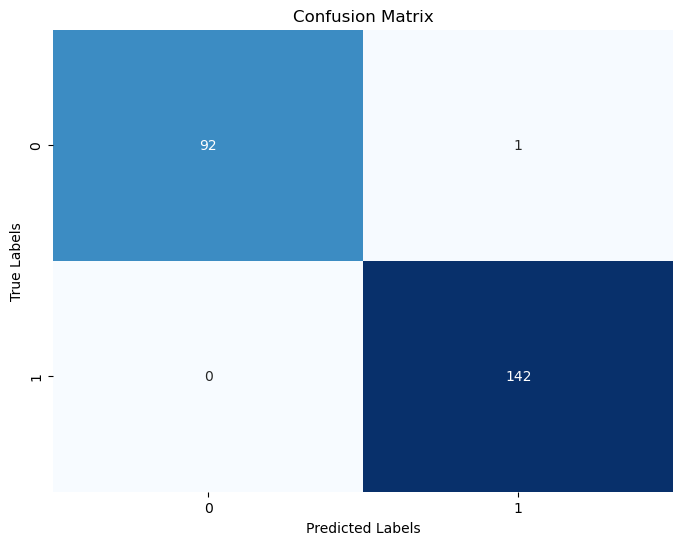

In [17]:
# Confusion matrix
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Generate confusion matrix
conf_matrix = confusion_matrix(y_test, clf.predict(X_test))
print("Confusion Matrix:\n", conf_matrix)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

**Exercise:** The training and test accuracies are unusually high. Can you propose a diagnosis for these results?

-- your response

In [ ]:
from sagemaker.sklearn.model import SKLearnModel
from time import gmtime, strftime

model_name = "Random-Forest-Model" + strftime("%Y-%m-%d-%H-%M-%S", gmtime())
model = SKLearnModel(
    name =  model_name,
    model_data=artifact,
    role=get_execution_role(),
    entry_point="inference2.py",
    framework_version=FRAMEWORK_VERSION,
)

In [1]:
import sagemaker
import boto3
from sagemaker.amazon.amazon_estimator import get_image_uri 
from sagemaker.session import s3_input, Session
     
bucket_name = 'malware-detector-model' # <--- CHANGE THIS VARIABLE TO A UNIQUE NAME FOR YOUR BUCKET
my_region = boto3.session.Session().region_name # set the region of the instance
print(my_region)

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/ec2-user/.config/sagemaker/config.yaml
us-east-1


In [13]:
import boto3
import sagemaker
from sagemaker.sklearn import SKLearnModel
from sagemaker import get_execution_role, Session

session = Session()

# Define the role
role = get_execution_role()

s3 = boto3.client("s3")

# Define your model artifact location in S3
model_data = session.upload_data(
        path="model.tar.gz", bucket=session.default_bucket(), key_prefix="models/sklearn"
    )

# Create a SageMaker model
model = SKLearnModel(model_data=model_data,
                     role=role,
                     entry_point='inference.py',  # Your inference script
                     framework_version='0.20.0',
                     py_version='py3')




In [4]:
import os
os.getcwd()

'/home/ec2-user/SageMaker'

In [28]:
import s3fs
s3_file = s3fs.S3FileSystem()
local_path = "/home/ec2-user/SageMaker/Samples/"
s3_path = "malware-detector-model/data"
s3_file.put(local_path, s3_path, recursive=True) 